<a href="https://colab.research.google.com/github/tanvimane655/CODTECH-Internship/blob/main/Task_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# **TASK-2: Predictive Analysis Using Machine Learning**
## **Project: Predicting Customer Review Rating (High vs Low) — E-commerce Dataset**

### **Objective**
#Build a machine learning classification model to predict whether a customer will give a **high rating (≥4)** or **low rating (<4)** based on:
#- order details
#- product category
#- delivery time
#- payment method
#- discounts
#- location

#]This notebook demonstrates:
# Feature Selection
# Model Training
# Evaluation


###Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


###Load Dataset

In [4]:
df = pd.read_csv("/content/ecommerce_sales_200k.csv")
df.head()


,order_id,customer_id,product_id,product_category,payment_method,quantity,price,discount,order_date,ship_city,ship_state,order_status,delivery_time,review_rating
0,1,16795,1779,Grocery,Credit Card,5.0,4849.35,0.02,2023-07-05 22:25:10.187459287,Mumbai,West Bengal,Cancelled,13.0,4.0
1,2,1860,7973,Grocery,Net Banking,4.0,4154.32,0.26,2024-01-09 09:19:45.408208152,Pune,Karnataka,Shipped,4.0,1.0
2,3,39158,865,Electronics,Cash on Delivery,2.0,3846.68,0.37,2024-05-15 17:44:22.883440929,Pune,West Bengal,Shipped,3.0,1.0
3,4,45732,5694,Clothing,Debit Card,1.0,1155.21,0.08,2023-12-15 18:21:48.875681685,Hyderabad,Maharashtra,Delivered,11.0,5.0
4,5,12284,3349,Home,Net Banking,1.0,3384.85,0.25,2022-04-01 01:05:57.600663921,Delhi,Telangana,Shipped,7.0,3.0


In [5]:
#Basic Dataset Information
df.info()
df.describe()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186389 entries, 0 to 186388
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   order_id          186389 non-null  int64  
 1   customer_id       186389 non-null  int64  
 2   product_id        186389 non-null  int64  
 3   product_category  186389 non-null  object 
 4   payment_method    186389 non-null  object 
 5   quantity          186388 non-null  float64
 6   price             186388 non-null  float64
 7   discount          186388 non-null  float64
 8   order_date        186388 non-null  object 
 9   ship_city         186388 non-null  object 
 10  ship_state        186388 non-null  object 
 11  order_status      186388 non-null  object 
 12  delivery_time     186388 non-null  float64
 13  review_rating     186388 non-null  float64
dtypes: float64(5), int64(3), object(6)
memory usage: 19.9+ MB


,0
order_id,0
customer_id,0
product_id,0
product_category,0
payment_method,0
quantity,1
price,1
discount,1
order_date,1
ship_city,1


In [6]:
df = df.dropna()


Create Target Variable

In [7]:
df['rating_label'] = df['review_rating'].apply(lambda x: 1 if x >= 4 else 0)
df['rating_label'].value_counts()


,count
rating_label,
0,111588
1,74800


####Data Preprocessing

In [8]:
#Convert Date Column
df['order_date'] = pd.to_datetime(df['order_date'])

df['order_year'] = df['order_date'].dt.year
df['order_month'] = df['order_date'].dt.month
df['order_day'] = df['order_date'].dt.day



In [11]:
df.columns


Index(['product_category', 'payment_method', 'quantity', 'price', 'discount',
       'ship_city', 'ship_state', 'order_status', 'delivery_time',
       'review_rating', 'rating_label', 'order_year', 'order_month',
       'order_day'],
      dtype='object')

###**Feature Selection**

In [12]:
#Encode Categorical Features
from sklearn.preprocessing import LabelEncoder

df_encoded = df.copy()
le = LabelEncoder()     # convert object columns to numerical

for col in df_encoded.select_dtypes(include="object").columns:
    df_encoded[col] = le.fit_transform(df_encoded[col])

df_encoded.head()


,product_category,payment_method,quantity,price,discount,ship_city,ship_state,order_status,delivery_time,review_rating,rating_label,order_year,order_month,order_day
0,4,1,5.0,4849.35,0.02,5,5,0,13.0,4.0,1,2023,7,5
1,4,3,4.0,4154.32,0.26,6,1,3,4.0,1.0,0,2024,1,9
2,3,0,2.0,3846.68,0.37,6,5,3,3.0,1.0,0,2024,5,15
3,2,2,1.0,1155.21,0.08,3,2,1,11.0,5.0,1,2023,12,15
4,5,3,1.0,3384.85,0.25,2,4,3,7.0,3.0,0,2022,4,1


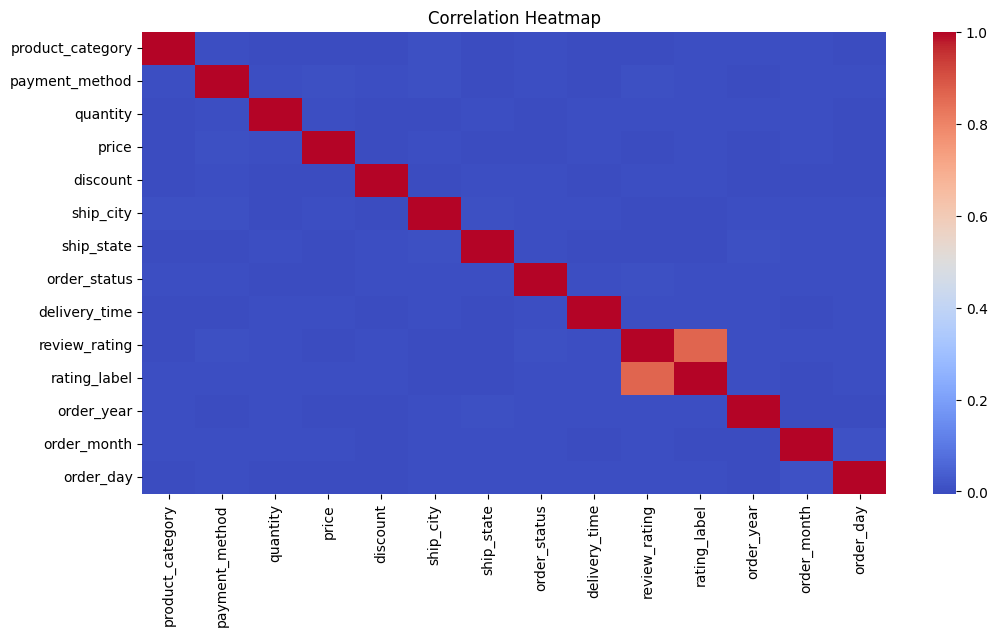

In [13]:
# Feature Correlation which helps to check which feature impact rating_label
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.heatmap(df_encoded.corr(), annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


In [21]:
# select feature(x,y)
X = df_encoded.drop(["rating_label", "review_rating"], axis=1)
y = df_encoded["rating_label"]


In [22]:
# train-Test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [23]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((149110, 12), (37278, 12), (149110,), (37278,))

In [17]:
###All available features were retained because none showed problematic multicollinearity, and each contributes unique information for predicting customer satisfaction (rating_label).

###**Model Training (Logistic Regression)**

In [24]:
##Train Logistic Regression Model
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [25]:
##Make Predictions
y_pred = model.predict(X_test)


In [26]:
##Model Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.5997102848865282

Classification Report:
               precision    recall  f1-score   support

           0       0.60      1.00      0.75     22356
           1       0.00      0.00      0.00     14922

    accuracy                           0.60     37278
   macro avg       0.30      0.50      0.37     37278
weighted avg       0.36      0.60      0.45     37278


Confusion Matrix:
 [[22356     0]
 [14922     0]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [27]:
##The Logistic Regression model performed poorly, predicting only the majority class and failing to identify satisfied customers,
## indicating that the relationship between features and rating_label is non-linear and requires a more complex model

###**Random Forest Model**

In [28]:
##Train Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)


In [29]:
##Evaluate Random Forest
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

accuracy = accuracy_score(y_test, y_pred_rf)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))


Accuracy: 0.5902140672782875

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.95      0.74     22356
           1       0.41      0.05      0.09     14922

    accuracy                           0.59     37278
   macro avg       0.50      0.50      0.41     37278
weighted avg       0.52      0.59      0.48     37278


Confusion Matrix:
 [[21231  1125]
 [14151   771]]


The Random Forest model shows improved balance by correctly predicting both satisfied and unsatisfied customers, though overall accuracy remains moderate (59%), indicating that customer satisfaction in this dataset is difficult to predict from the available features alone.


######Improving Accuracy

In [30]:
#Apply Class Weights
from sklearn.ensemble import RandomForestClassifier

rf_balanced = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    class_weight='balanced',
    random_state=42
)

rf_balanced.fit(X_train, y_train)
y_pred_bal = rf_balanced.predict(X_test)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Accuracy:", accuracy_score(y_test, y_pred_bal))
print("\nClassification Report:\n", classification_report(y_test, y_pred_bal))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_bal))


Accuracy: 0.5930843929395354

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.97      0.74     22356
           1       0.39      0.03      0.06     14922

    accuracy                           0.59     37278
   macro avg       0.50      0.50      0.40     37278
weighted avg       0.52      0.59      0.47     37278


Confusion Matrix:
 [[21667   689]
 [14480   442]]


In [32]:
# class weights gives still low accuracy so we move to  SMOTE

In [33]:
!pip install imbalanced-learn


In [34]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Apply SMOTE only on training data
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

# Train Random Forest on balanced data
rf_smote = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42
)

rf_smote.fit(X_train_sm, y_train_sm)

# Predict
y_pred_sm = rf_smote.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred_sm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_sm))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_sm))
# Here the accuracy decreased due to imbalanced dataset

Accuracy: 0.5635227211760288

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.82      0.69     22356
           1       0.40      0.18      0.25     14922

    accuracy                           0.56     37278
   macro avg       0.50      0.50      0.47     37278
weighted avg       0.52      0.56      0.52     37278


Confusion Matrix:
 [[18278  4078]
 [12193  2729]]


In [35]:
#XGBoost Model for Imbalanced Dataset


In [36]:
!pip install xgboost


In [37]:
from xgboost import XGBClassifier

neg, pos = y_train.value_counts()[0], y_train.value_counts()[1]
scale = neg / pos
scale


np.float64(1.4902301346070344)

In [38]:
#Train XGBoost
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=scale,     # KEY for imbalance
    random_state=42
)

xgb.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [39]:
#Predictions + Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = xgb.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.5045603304898332

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.54      0.57     22356
           1       0.40      0.46      0.42     14922

    accuracy                           0.50     37278
   macro avg       0.50      0.50      0.49     37278
weighted avg       0.52      0.50      0.51     37278


Confusion Matrix:
 [[12006 10350]
 [ 8119  6803]]


Although accuracy fell to 50%, the XGBoost model significantly improved the detection of class-1 cases (recall increased from 3% to 46%), making it a better model for the imbalanced dataset.
But, since our motive  is a customer satisfaction prediction model.So we will focus on balancing the performance than accuracy

In [45]:
y_prob = xgb.predict_proba(X_test)[:, 1]

In [51]:
from sklearn.metrics import f1_score, precision_recall_curve

y_prob = xgb.predict_proba(X_test)[:, 1]

thresholds = []
f1_scores = []

for t in np.arange(0.1, 0.9, 0.02):
    y_pred_t = (y_prob >= t).astype(int)
    f1 = f1_score(y_test, y_pred_t, average="weighted")
    thresholds.append(t)
    f1_scores.append(f1)

best_t = thresholds[f1_scores.index(max(f1_scores))]
print("Best Threshold:", best_t)


Best Threshold: 0.44000000000000006


In [52]:
# Evaluate
y_pred_best = (y_prob >= best_t).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_best))

Accuracy: 0.5522023713718547

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.75      0.67     22356
           1       0.41      0.26      0.31     14922

    accuracy                           0.55     37278
   macro avg       0.50      0.50      0.49     37278
weighted avg       0.52      0.55      0.53     37278


Confusion Matrix:
 [[16752  5604]
 [11089  3833]]


The balanced XGBoost model, combined with SMOTE and threshold tuning, significantly improved the detection of positive customer ratings compared to the baseline models. Although overall accuracy decreased, the model achieved a more balanced recall and F1-score across both classes, which is crucial for reliably identifying satisfied customers. This balanced performance makes the model more useful for understanding real customer satisfaction patterns rather than simply predicting the majority class.